# Equations with first order term

In [1]:
!test -d /var/colab && pip install poetry
!test -d /var/colab && pip install git+https://github.com/gbonnet1/notebooks.git

In [2]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation import Dense2, Sparse
from agd.AutomaticDifferentiation.misc import tocsr
from agd.AutomaticDifferentiation.Optimization import newton_root
from scipy.sparse import diags
from scipy.sparse.linalg import eigs, spsolve

In [3]:
def domain(d):
    return Domain.Union(
        Domain.Ball(center=d * [0]),
        Domain.Box(sides=d * [(0, 1)]),
    )

In [4]:
def grid(d, h):
    return np.stack(
        np.meshgrid(
            *(d * [np.arange(-h * np.floor(1 / h), 1, h)]),
            indexing="ij",
        )
    )

In [5]:
def omega0(x):
    d = x.shape[0]

    if d == 2:
        return np.stack([np.cos(np.pi * x[1]), np.sin(np.pi * x[1])])
    elif d == 3:
        return np.stack(
            [
                np.cos(np.pi * x[1]),
                np.sin(np.pi * x[1]) * np.cos(np.pi * x[2]),
                np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]),
            ]
        )
    else:
        raise ValueError(f"Invalid dimension: {d}")


def omega(x):
    return (2 - np.cos(np.pi * x[0])) / 3 * omega0(x)


def D(x):
    return (
        mu
        * (2 + np.cos(np.pi * x[0]))
        / 3
        * (
            nu * lp.identity(x.shape[1:])
            + (1 - nu) * lp.outer(omega0(x / 2), omega0(x / 2))
        )
    )

In [6]:
def u1(x):
    return 1 / 4 * lp.dot_VV(x, x) ** 2


def u2(x):
    return np.maximum(0, np.sqrt(lp.dot_VV(x, x)) - 0.4) ** 2.5


def u3(x):
    d = x.shape[0]
    return np.where(lp.dot_VV(x, x) < d, np.sqrt(d - lp.dot_VV(x, x)), 0)

In [7]:
def EqLinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return -lp.dot_VV(omega(x), du) - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeLinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))

    # coef_min = np.min(coef)
    # offsets_norm2 = lp.dot_VV(offsets, offsets)
    # offsets_max2 = np.max(np.where(coef < 1e-13, 0, offsets_norm2))
    # print(f"h: {bc.gridscale}, c: {coef_min}, e2: {offsets_max2}")

    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    return np.where(
        bc.interior,
        -lp.dot_VAV(omega(x), lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
        - lp.dot_VV(coef, d2u)
        - f,
        u - bc.grid_values,
    )


def SolveLinear(x, f, bc):
    u = Sparse.identity(constant=np.zeros(x.shape[1:]))
    residue = SchemeLinear(u, x, f, bc)

    triplets, rhs = residue.solve(raw=True)
    mat = tocsr(triplets)

    if False:
        (val_max,), _ = eigs(mat, 1, which="LM")
        (val_min,), _ = eigs(mat, 1, which="SM")
        print(val_max / val_min)

    dde = (diags(mat.diagonal()) - mat).min() > -1e-8

    precond = diags(1 / mat.diagonal())
    matprecond = precond @ mat
    rhsprecond = precond @ rhs

    if False:
        (val_max,), _ = eigs(matprecond, 1, which="LM")
        (val_min,), _ = eigs(matprecond, 1, which="SM")
        print(val_max / val_min)

    return spsolve(matprecond, rhsprecond).reshape(x.shape[1:]), dde

In [8]:
def EqNonlinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return -1 / 2 * lp.dot_VV(omega(x), du) ** 2 - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeNonlinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))
    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    p = lp.dot_AV(lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
    return np.where(
        bc.interior,
        -1 / 2 * lp.dot_VV(omega(x), p) ** 2 - lp.dot_VV(coef, d2u) - f,
        u - bc.grid_values,
    )


def SolveNonlinear(x, f, bc):
    dde = True

    def Solver(residue):
        nonlocal dde

        triplets, rhs = residue.solve(raw=True)
        mat = tocsr(triplets)

        # if (diags(mat.diagonal()) - mat).min() <= -1e-8:
        #     dde = False

        dde = (diags(mat.diagonal()) - mat).min() > -1e-8

        precond = diags(1 / mat.diagonal())
        matprecond = precond @ mat
        rhsprecond = precond @ rhs

        return spsolve(matprecond, rhsprecond).reshape(x.shape[1:])

    result = newton_root(
        SchemeNonlinear, 0.0001 * lp.dot_VV(x, x), params=(x, f, bc), solver=Solver
    )

    return result, dde

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


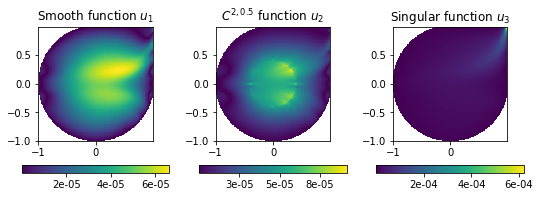

In [9]:
d = 2
mu = 1
nu = 1 / 10
h = 0.01

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    x = grid(d, h)
    bc = Domain.Dirichlet(domain(d), u_func, x)

    u = u_func(x)
    f = EqLinear(u_func, x)

    u_approx, _ = SolveLinear(x, f, bc)

    plt.subplot(131 + i, aspect="equal")
    plt.title(title)
    im = plt.pcolormesh(*x, np.where(bc.interior, np.abs(u - u_approx), np.nan))
    plt.colorbar(im, orientation="horizontal", format="%.0e")

plt.savefig("linear-error-2d.png")
plt.show()

0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 True
0.05743491774985175 True
0.05 True
0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True
*** threshold: 0.0659753955386447 ***
0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 True
0.05743491774985175 True
0.05 True


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True
*** threshold: 0.0659753955386447 ***
0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 True
0.05743491774985175 True
0.05 True


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True
*** threshold: 0.0659753955386447 ***


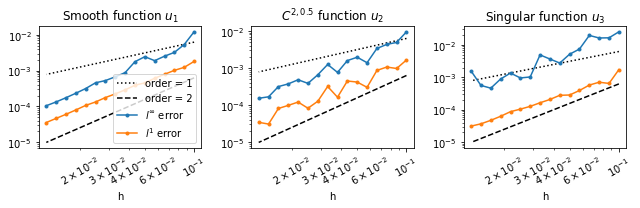

In [10]:
d = 2
mu = 1
nu = 1 / 10
h = 0.1 / 2 ** np.arange(0, 3.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)
    threshold = "any"

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx, dde = SolveLinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            threshold = "none"
        elif threshold == "none":
            threshold = h[j]

        # if not dde:
        #     plt.axvspan(
        #         np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
        #         np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
        #         color="lightgray",
        #     )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    print(f"*** threshold: {threshold} ***")

    plt.loglog(h, h / 16, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 16, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("linear-convergence-2d.png")
plt.show()

Iteration: 1  Residue norm: 35.037252564400404
Iteration: 2  Residue norm: 1.9319693641272155
Iteration: 3  Residue norm: 0.007258021723767438
Iteration: 4  Residue norm: 1.0369830150125381e-07
Iteration: 5  Residue norm: 1.7763568394002505e-14
Target residue reached. Terminating.
0.1 True
Iteration: 1  Residue norm: 51.89159624646246
Iteration: 2  Residue norm: 2.597182257736199
Iteration: 3  Residue norm: 0.031180985236980874
Iteration: 4  Residue norm: 4.7357150796401015e-06
Iteration: 5  Residue norm: 1.092459456231154e-13
Target residue reached. Terminating.
0.08705505632961241 False
Iteration: 1  Residue norm: 438.2796222081457
Iteration: 2  Residue norm: 58.594615869901574
Iteration: 3  Residue norm: 1.9303034686309442
Iteration: 4  Residue norm: 0.0023968653549606422
Iteration: 5  Residue norm: 3.712450791226729e-09
Target residue reached. Terminating.
0.07578582832551992 False
Iteration: 1  Residue norm: 1905.1445812771606
Iteration: 2  Residue norm: 396.28453683104
Iteration:

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


Iteration: 3  Residue norm: 0.05340507638033465
Iteration: 4  Residue norm: 1.3652982751466425e-05
Iteration: 5  Residue norm: 9.001688283660769e-13
Target residue reached. Terminating.
0.08705505632961241 False
Iteration: 1  Residue norm: 525.3013171628438
Iteration: 2  Residue norm: 75.8128412544155
Iteration: 3  Residue norm: 3.0837109491710923
Iteration: 4  Residue norm: 0.006035160681774787
Iteration: 5  Residue norm: 2.328875847723566e-08
Iteration: 6  Residue norm: 3.2152058793144533e-13
Target residue reached. Terminating.
0.07578582832551992 False
Iteration: 1  Residue norm: 2302.827455740751
Iteration: 2  Residue norm: 492.65849439251525
Iteration: 3  Residue norm: 68.60847106451632
Iteration: 4  Residue norm: 9.41277959581226
Iteration: 5  Residue norm: 0.7546609370257173
Iteration: 6  Residue norm: 0.006880459941369654
Iteration: 8  Residue norm: 9.565681580170349e-13
Target residue reached. Terminating.
0.0659753955386447 True
Iteration: 1  Residue norm: 238.35654825414963

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


Iteration: 2  Residue norm: 91.17054353225491
Iteration: 3  Residue norm: 11.925369263499398
Iteration: 4  Residue norm: 0.6840991415155475
Iteration: 5  Residue norm: 0.00288936307237897
Iteration: 6  Residue norm: 5.254574131363654e-08
Iteration: 7  Residue norm: 4.249933738265099e-13
Target residue reached. Terminating.
0.08705505632961241 False
Iteration: 1  Residue norm: 4834.18047971441
Iteration: 2  Residue norm: 1134.837872227957
Iteration: 3  Residue norm: 218.79264055610156
Iteration: 4  Residue norm: 21.453158045061343
Iteration: 5  Residue norm: 0.3184336870213377
Iteration: 6  Residue norm: 7.445496025482168e-05
Iteration: 7  Residue norm: 3.870348486145758e-12
Target residue reached. Terminating.
0.07578582832551992 False
Iteration: 1  Residue norm: 23710.23249836744
Iteration: 2  Residue norm: 5850.743738689821
Iteration: 3  Residue norm: 1383.1724024423604
Iteration: 4  Residue norm: 277.82861253618466
Iteration: 5  Residue norm: 31.29436829144959
Iteration: 6  Residue 

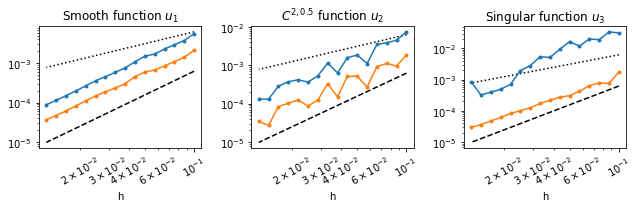

In [11]:
d = 2
mu = 2
nu = 1 / 10
h = 0.1 / 2 ** np.arange(0, 3.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)
    threshold = "any"

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx, dde = SolveNonlinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            threshold = "none"
        elif threshold == "none":
            threshold = h[j]

        # if not dde:
        #     plt.axvspan(
        #         np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
        #         np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
        #         color="lightgray",
        #     )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    print(f"*** threshold: {threshold} ***")

    plt.loglog(h, h / 16, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 16, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    # if i == 0:
    #     plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("nonlinear-convergence-2d.png")
plt.show()

0.3 True
0.26116516898883724 False
0.22735748497655972 False
0.1979261866159341 True
0.17230475324955524 True
0.15 True
0.13058258449441862 True
0.11367874248827983 True
0.09896309330796706 True
0.08615237662477762 True
0.075 True
*** threshold: 0.1979261866159341 ***
0.3 True
0.26116516898883724 False
0.22735748497655972 False
0.1979261866159341 True


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


0.17230475324955524 True
0.15 True
0.13058258449441862 True
0.11367874248827983 True
0.09896309330796706 True
0.08615237662477762 True
0.075 True
*** threshold: 0.1979261866159341 ***
0.3 True
0.26116516898883724 False
0.22735748497655972 False
0.1979261866159341 True
0.17230475324955524 True
0.15 True
0.13058258449441862 True
0.11367874248827983 True
0.09896309330796706 True
0.08615237662477762 True
0.075 True
*** threshold: 0.1979261866159341 ***


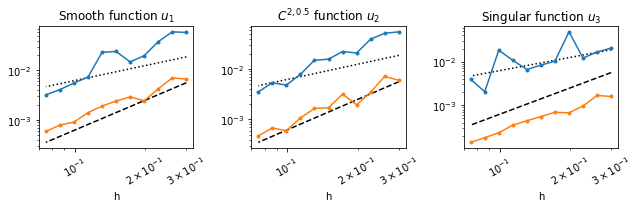

In [12]:
d = 3
mu = 4
nu = 1 / 10
h = 0.3 / 2 ** np.arange(0, 2.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)
    threshold = "any"

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx, dde = SolveLinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            threshold = "none"
        elif threshold == "none":
            threshold = h[j]

        # if not dde:
        #     plt.axvspan(
        #         np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
        #         np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
        #         color="lightgray",
        #     )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    print(f"*** threshold: {threshold} ***")

    plt.loglog(h, h / 16, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 16, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    # if i == 0:
    #     plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("linear-convergence-3d.png")
plt.show()

Iteration: 1  Residue norm: 255.5086401591359
Iteration: 2  Residue norm: 43.167937662496556
Iteration: 3  Residue norm: 2.805744942917607
Iteration: 4  Residue norm: 0.015657369354764583
Iteration: 5  Residue norm: 4.986146571184236e-07
Iteration: 6  Residue norm: 8.526512829121202e-14
Target residue reached. Terminating.
0.3 False
Iteration: 1  Residue norm: 30.978888306450507
Iteration: 2  Residue norm: 1.3566632382375765
Iteration: 3  Residue norm: 0.0031096197941913317
Iteration: 4  Residue norm: 1.647915226499208e-08
Iteration: 5  Residue norm: 1.7763568394002505e-14
Target residue reached. Terminating.
0.26116516898883724 True
Iteration: 1  Residue norm: 109.0508804249553
Iteration: 2  Residue norm: 5.0809218889753005
Iteration: 3  Residue norm: 0.03454180459675538
Iteration: 4  Residue norm: 1.6402799269954471e-06
Iteration: 5  Residue norm: 3.552713678800501e-14
Target residue reached. Terminating.
0.22735748497655972 False
Iteration: 1  Residue norm: 2149.7423515891282
Iterat

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


Iteration: 3  Residue norm: 0.06157542762669266
Iteration: 4  Residue norm: 5.144777074583828e-06
Iteration: 5  Residue norm: 8.881784197001252e-14
Target residue reached. Terminating.
0.22735748497655972 True
Iteration: 1  Residue norm: 2121.1561373465584
Iteration: 2  Residue norm: 494.84008758873404
Iteration: 3  Residue norm: 94.27751145864602
Iteration: 4  Residue norm: 8.931762051037744
Iteration: 5  Residue norm: 0.34597053434087854
Iteration: 6  Residue norm: 0.0008746752979540418
Iteration: 7  Residue norm: 5.628697508086589e-09
Target residue reached. Terminating.
0.1979261866159341 True
Iteration: 1  Residue norm: 165.30637183671345
Iteration: 2  Residue norm: 11.94703484639442
Iteration: 3  Residue norm: 0.2079811327034582
Iteration: 4  Residue norm: 6.765517167117707e-05
Iteration: 5  Residue norm: 7.146283564907208e-12
Target residue reached. Terminating.
0.17230475324955524 True
Iteration: 1  Residue norm: 385.789957245772
Iteration: 2  Residue norm: 43.58176681571826
It

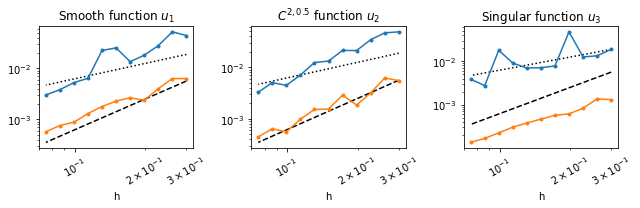

In [13]:
d = 3
mu = 8
nu = 1 / 10
h = 0.3 / 2 ** np.arange(0, 2.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)
    threshold = "any"

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx, dde = SolveNonlinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            threshold = "none"
        elif threshold == "none":
            threshold = h[j]

        # if not dde:
        #     plt.axvspan(
        #         np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
        #         np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
        #         color="lightgray",
        #     )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    print(f"*** threshold: {threshold} ***")

    plt.loglog(h, h / 16, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 16, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    # if i == 0:
    #     plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("nonlinear-convergence-3d.png")
plt.show()